In [1]:
import wikipedia as wp
data: wp.WikipediaPage = wp.page("List_of_Triangle_chapters")

chapters = {}
for uni in data.links:
    try:
        uni_search = wp.search(uni)[0]
        uni_data: wp.WikipediaPage = wp.page(uni_search)
        chapters[uni_search] = uni_data.coordinates
        print(uni_search, uni_data.coordinates)
    except KeyError as e:
        print(f"{uni} didn't have coordinates available.")
    except wp.PageError as e:
        print(f"{uni} could not be found.")

Arizona State University (Decimal('33.42099999999999937472239253111183643341064453125'), Decimal('-111.9330000000000069348971010185778141021728515625'))
California State Polytechnic University, Pomona (Decimal('34.05638889000000091300535132177174091339111328125'), Decimal('-117.8216666699999990441938280127942562103271484375'))
Carnegie Mellon University (Decimal('40.44250000000000255795384873636066913604736328125'), Decimal('-79.943333330000001524240360595285892486572265625'))
Clarkson University (Decimal('44.6634949999999975034370436333119869232177734375'), Decimal('-74.9990700000000032332536648027598857879638671875'))
Clemson University (Decimal('34.6783333300000009558061719872057437896728515625'), Decimal('-82.83916666999999733889126218855381011962890625'))
Colorado State University (Decimal('40.57483610999999967816620483063161373138427734375'), Decimal('-105.0809777799999977787592797540128231048583984375'))
Cornell University (Decimal('42.4472222200000004477260517887771129608154296

In [2]:
drops = [
    "United States",
    "Western United States",
    "Eastern United States",
    "Northern United States",
    "Southern United States"
]

for drop in drops:
    if drop in chapters.keys():
        del chapters[drop]
        print(f"{drop} dropped.")

United States dropped.
Western United States dropped.
Southern United States dropped.


In [3]:
for uni, coords in chapters.items():
    chapters[uni] = (
        float(coords[0]),
        float(coords[1])
    )

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopy as gpy
import geopandas as gpd

In [5]:
df = pd.DataFrame.from_dict(chapters, orient='index', columns=["lat", "long"])

gdf = gpd.GeoDataFrame(
    df,
    geometry = gpd.points_from_xy(
        df.long,
        df.lat
    )
)

gdf.head()

NameError: name 'gpd' is not defined

In [ ]:
drops = [
    "University of Iowa",
    "University of Missouri",
    "Northwestern University",
    "Cornell University",
    "Clarkson College",
    "Kansas State University",
    "Oklahoma State University",
    "Rochester Institute of Technology",
    "University of Colorado",
    "Mississippi State University",
    "University of Connecticut",
    "University of Texas at Arlington",
    "Texas A&M University",
    "Trine University",
    "University of Akron",
    "Northern Illinois University",
    "University of Maryland, Baltimore County",
    "University of Houston",
    "University of California, Berkeley",
    "Florida Atlantic University",
    "Southern Illinois University",
    "University of Arizona",
    "University of Maryland",
    "Mantako State University",
    "Tennessee Technological University",
    "Wright State University",
    "University of Florida",
    "Oregon State University",
    "New Jersey Institute of Technology",
    "Carnegie Mellon University",
    "Florida Institute of Technology",
    "Georgia Institute of Technology",
    "Arizona State University"
]

gdf["Status"] = np.array([int(not i in drops) for i in gdf.index])
gdf

,lat,long,geometry,Status
Arizona State University,33.421000,-111.933000,POINT (-111.93300 33.42100),0
"California State Polytechnic University, Pomona",34.056389,-117.821667,POINT (-117.82167 34.05639),1
Carnegie Mellon University,40.442500,-79.943333,POINT (-79.94333 40.44250),0
Clarkson University,44.663495,-74.999070,POINT (-74.99907 44.66349),1
Clemson University,34.678333,-82.839167,POINT (-82.83917 34.67833),1
...,...,...,...,...
University of Washington,47.654167,-122.308056,POINT (-122.30806 47.65417),1
University of Wisconsin–Madison,43.075000,-89.417222,POINT (-89.41722 43.07500),1
University of Wisconsin–Milwaukee,43.075030,-87.882915,POINT (-87.88291 43.07503),1
Virginia Commonwealth University,37.546615,-77.453255,POINT (-77.45325 37.54662),1


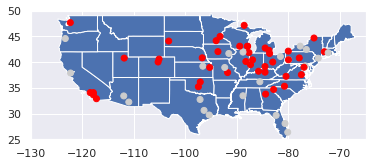

In [ ]:

world = gpd.read_file("data/States_shapefile.shp")

ax = world.plot()
plt.xlim([-130, -65])
plt.ylim([25, 50])

color_map = {
    0: "#CCCCCC",
    1: "#FF0000"
}

gdf.plot(
    ax=ax,
    color=gdf["Status"].map(color_map)
)

plt.show()

In [ ]:
import json
import requests
import yaml

with open(r'secrets.yaml') as file:
    API_KEY = yaml.load(file, Loader=yaml.FullLoader)["API_KEY"]

def get_travel_time(orig, dest):

    # google API url 
    url = f"https://maps.googleapis.com/maps/api/distancematrix/json?units=imperial&origins={orig}&destinations={dest}&key={API_KEY}"

    r = requests.get(url)

    results = json.loads(r.content)
    try:
        duration = results['rows'][0]['elements'][0]['duration']
        return duration['value'] / 3600
    except Exception as e:
        print(results)
        print(e)

In [ ]:
from geopy.distance import geodesic

closest_chapter = {}
closest_dist = {}
closest_time = {}

for chapter in gdf.index:
    closest_chapter[chapter] = None
    closest_dist[chapter] = 1e10

    for neighbor in gdf.index:
        if neighbor == chapter:
            continue

        chap = gdf.loc[chapter ]
        neig = gdf.loc[neighbor]

        if neig.Status == 0:
            continue

        dist = geodesic(
            (chap.lat, chap.long),
            (neig.lat, neig.long)
        ).mi

        if dist < closest_dist[chapter]:
            closest_chapter[chapter] = neighbor
            closest_dist[chapter] = dist

    # Once closest is found, calc travel time
    closest_time[chapter] = get_travel_time(chapter, closest_chapter[chapter])

In [ ]:
hq_addr = "120 South Center Street Plainfield, Indiana"
hq_latlong = (39.70215652386097, -86.40291718918972)
hq_dist = {}
hq_time = {}

for chapter in gdf.index:
    hq_dist[chapter] = geodesic(
        (gdf.loc[chapter].lat, gdf.loc[chapter].long),
        (hq_latlong[0], hq_latlong[1])
    )

    hq_time[chapter] = get_travel_time(chapter, hq_addr)

In [ ]:
gdf["Closest Chapter"] = pd.Series(closest_chapter)
gdf["Closest Dist"] = pd.Series(closest_dist)
gdf["Closest Time"] = pd.Series(closest_time)
gdf["HQ Dist"] = pd.Series(hq_dist)
gdf["HQ Time"] = pd.Series(hq_time)
gdf[gdf.Status == 1].sort_values(by="Closest Time")

,lat,long,geometry,Status,Closest Chapter,Closest Dist,Closest Time,HQ Dist,HQ Time
University of Wisconsin–Milwaukee,43.075030,-87.882915,POINT (-87.88291 43.07503),1,Marquette University,3.525485,0.181111,394.4998637553891 km,4.591667
Marquette University,43.039167,-87.932500,POINT (-87.93250 43.03917),1,University of Wisconsin–Milwaukee,3.525485,0.222778,392.062877578889 km,4.476667
"California State Polytechnic University, Pomona",34.056389,-117.821667,POINT (-117.82167 34.05639),1,"University of California, Irvine",28.340913,0.571389,2854.711146507067 km,29.680278
"University of California, Irvine",33.645556,-117.842500,POINT (-117.84250 33.64556),1,"California State Polytechnic University, Pomona",28.340913,0.611111,2873.7727745199877 km,30.114722
"University of California, Los Angeles",34.069444,-118.445278,POINT (-118.44528 34.06944),1,"California State Polytechnic University, Pomona",35.783394,0.727500,2907.605627193706 km,30.328056
University of Michigan,42.276944,-83.738056,POINT (-83.73806 42.27694),1,University of Toledo,43.215115,0.868056,363.3392149056042 km,4.451389
University of Toledo,41.657716,-83.613660,POINT (-83.61366 41.65772),1,University of Michigan,43.215115,0.885833,320.53264987162197 km,3.885000
Michigan State University,42.725000,-84.480000,POINT (-84.48000 42.72500),1,University of Michigan,48.912647,0.955833,372.40609403235106 km,4.231944
"University of California, San Diego",32.880100,-117.234000,POINT (-117.23400 32.88010),1,"University of California, Irvine",63.433981,1.050556,2855.5237045349368 km,30.277778
Colorado State University,40.574836,-105.080978,POINT (-105.08098 40.57484),1,University of Colorado Boulder,40.418240,1.055000,1591.7227862749435 km,16.444444


In [ ]:
import seaborn as sns
from matplotlib.gridspec import GridSpec

In [ ]:
%matplotlib inline

<Figure size 432x288 with 0 Axes>

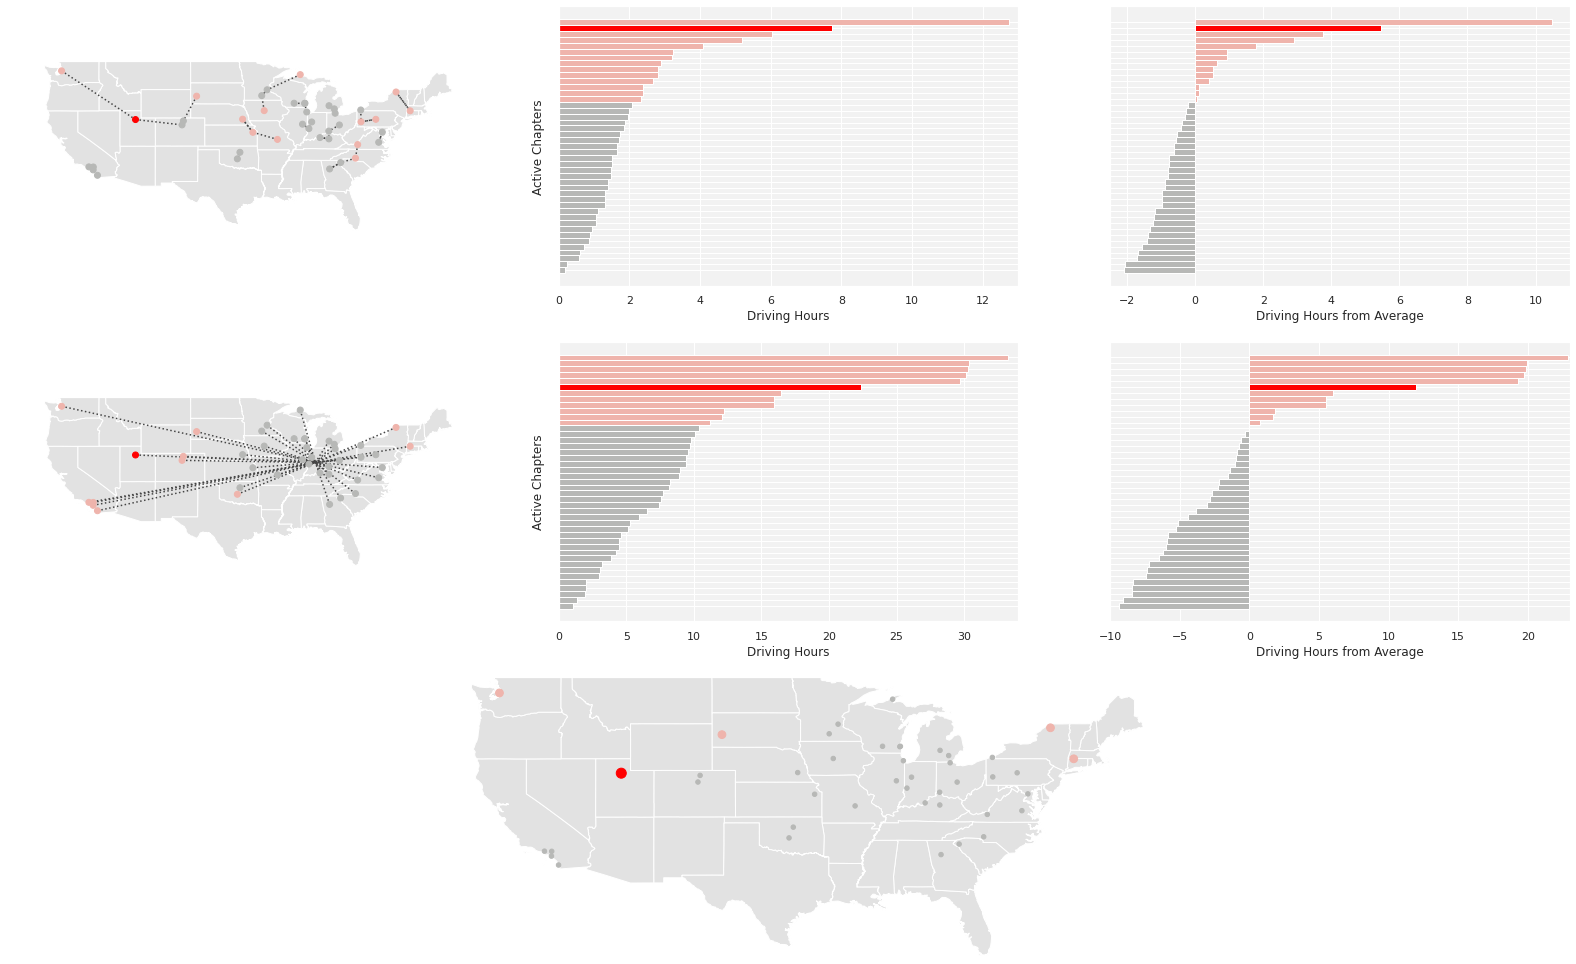

In [ ]:
sns.set_theme()
plt.tight_layout()

fig: plt.Figure = plt.figure(figsize=(28, 16))
fig.subplots_adjust(top=0.95)
gs = GridSpec(nrows=3, ncols=3)

agdf = gdf.drop(gdf[gdf.Status == 0].index)
agdf["Closest Median"] = agdf["Closest Time"] - agdf["Closest Time"].median()
agdf["Closest Average"] = agdf["Closest Time"] - agdf["Closest Time"].mean()
agdf["HQ Median"] = agdf["HQ Time"] - agdf["HQ Time"].median()
agdf["HQ Average"] = agdf["HQ Time"] - agdf["HQ Time"].mean()
agdf["Isolated"] = np.logical_and(
    (agdf["Closest Average"] >= 0),
    (agdf["HQ Average"] >= 0)
).astype(int)

world = gpd.read_file("data/States_shapefile.shp")

# ==========
# GRID
# ==========

cl_map: plt.Axes = fig.add_subplot(gs[0,0])
cl_abs: plt.Axes = fig.add_subplot(gs[0,1])
cl_rel: plt.Axes = fig.add_subplot(gs[0,2])

hq_map: plt.Axes = fig.add_subplot(gs[1,0])
hq_abs: plt.Axes = fig.add_subplot(gs[1,1])
hq_rel: plt.Axes = fig.add_subplot(gs[1,2])

iso_map: plt.Axes = fig.add_subplot(gs[2, :])

# ==========
# LIMITS
# ==========
cl_abs.set_xlim([0, 13])
cl_rel.set_xlim([-2.5, 11])

hq_abs.set_xlim([0, 34])
hq_rel.set_xlim([-10, 23])

# ==========
# CLOSEST
# ==========

cl_df = agdf.sort_values(by="Closest Time")
cl_colors = (cl_df["Closest Average"] >= 0).astype(int)
cl_colors.at["University of Utah"] = 2
cl_colors = cl_colors.map({
    0: "#B7B8B6",
    1: "#EFB4AC",
    2: "#FF0000"
})

cl_map.set_xlim([-130, -65])
cl_map.set_ylim([25, 49])
cl_map.xaxis.set_ticklabels([])
cl_map.yaxis.set_ticklabels([])
cl_map.set_facecolor("#FFFFFF")
world.plot(
    ax = cl_map,
    color = "#E2E2E2",
    edgecolor="#FFFFFF",
#    linewidth=4
)

# Add lines between closest neighbors
for chapter in cl_df.index:
    orig = cl_df.loc[chapter].geometry
    dest = cl_df.loc[cl_df.loc[chapter]["Closest Chapter"]].geometry
    cl_map.plot(
        [orig.x, dest.x],
        [orig.y, dest.y],
        linestyle = "dotted",
        color = "#444444",
        zorder=1
    )

cl_df["geometry"].plot(
    ax = cl_map,
    color = cl_colors,
    zorder=2
)

cl_abs.set_facecolor("#F2F2F2")
cl_abs.barh(
    cl_df.index,
    cl_df["Closest Time"],
    color = cl_colors,
    height = 1
)
cl_abs.yaxis.set_ticklabels([])
cl_abs.set_ylabel("Active Chapters")
cl_abs.set_xlabel("Driving Hours")

cl_rel.set_facecolor("#F2F2F2")
cl_rel.barh(
    cl_df.index,
    cl_df["Closest Average"],
    color = cl_colors,
    height = 1
)
cl_rel.yaxis.set_ticklabels([])
cl_rel.set_ylabel("")
cl_rel.set_xlabel("Driving Hours from Average")


# ==========
# HQ
# ==========

hq_df = agdf.sort_values(by="HQ Time")
hq_colors = (hq_df["HQ Average"] >= 0).astype(int)
hq_colors.at["University of Utah"] = 2
hq_colors = hq_colors.map({
    0: "#B7B8B6",
    1: "#EFB4AC",
    2: "#FF0000"
})

hq_map.set_xlim([-130, -65])
hq_map.set_ylim([25, 49])
hq_map.xaxis.set_ticklabels([])
hq_map.yaxis.set_ticklabels([])
hq_map.set_facecolor("#FFFFFF")
world.plot(
    ax = hq_map,
    color = "#E2E2E2",
    edgecolor="#FFFFFF",
    # linewidth=4
)

# Add lines between closest neighbors
for chapter in hq_df.index:
    orig = hq_df.loc[chapter].geometry
    hq_map.plot(
        [orig.x, hq_latlong[1]],
        [orig.y, hq_latlong[0]],
        linestyle = "dotted",
        color = "#444444",
        zorder=1
    )

hq_df["geometry"].plot(
    ax = hq_map,
    color = hq_colors,
    zorder=2
)

hq_abs.set_facecolor("#F2F2F2")
hq_abs.barh(
    hq_df.index,
    hq_df["HQ Time"],
    color = hq_colors,
    height = 1
)
hq_abs.yaxis.set_ticklabels([])
hq_abs.set_ylabel("Active Chapters")
hq_abs.set_xlabel("Driving Hours")


hq_rel.set_facecolor("#F2F2F2")
hq_rel.barh(
    hq_df.index,
    hq_df["HQ Average"],
    color = hq_colors,
    height = 1
)
hq_rel.yaxis.set_ticklabels([])
hq_rel.set_ylabel("")
hq_rel.set_xlabel("Driving Hours from Average")


# ==========
# ISOLATED
# ==========

iso_colors = agdf["Isolated"]
iso_colors.at["University of Utah"] = 2
iso_colors = iso_colors.map({
    0: "#B7B8B6",
    1: "#EFB4AC",
    2: "#FF0000"
})

BIG = 40
SMALL = 20
iso_sizes = (agdf["Isolated"] * BIG) + SMALL

iso_map.set_xlim([-130, -65])
iso_map.set_ylim([25, 49])
iso_map.xaxis.set_ticklabels([])
iso_map.yaxis.set_ticklabels([])
iso_map.set_facecolor("#FFFFFF")
world.plot(
    ax = iso_map,
    color = "#E2E2E2",
    edgecolor="#FFFFFF",
#    linewidth=4
)

agdf["geometry"].plot(
    ax = iso_map,
    color = iso_colors,
    zorder=2,
    markersize = iso_sizes
)


plt.savefig("figures/distances.pdf", format="pdf", dpi=750)
plt.show()